In [20]:
class job:
    def __init__(self, timeCPU, timeGPU):
        """A job is just a CPU rutime and a GPU runtime"""
        self.timeCPU = timeCPU
        self.timeGPU = timeGPU

    def __str__(self) -> str:
        return f"({self.timeCPU:.2f}, {self.timeGPU:.2f})"


class processor:
    def __init__(self, processorType: str):
        """Processor takes a type and maintains a runtime"""
        self.duration: float = 0.0
        self.processorType = processorType
        self.jobTimes = []

    def get_runtime(self):
        return self.duration

    def get_type(self):
        return self.processorType

    def add_job(self, duration):
        """Takes the length of the next job to run"""
        if duration < 0.0:
            raise RuntimeError("Jobs must take non-negative time")
        self.duration += duration
        # Track the individual job lengths too
        self.jobTimes.append(duration)

    def __str__(self) -> str:
        return f"Duration: {self.duration} | {str(self.jobTimes)}"

    # We can define __lt__ etc. and use them in a heap maybe


class system:
    def __init__(self, CPU_count, GPU_count, CPU_type_name="CPU", GPU_type_name="GPU"):
        """A system is a number of CPU and GPU cores with at least one of each"""
        if CPU_count < 1:
            raise RuntimeError("Must have at least 1 CPU")
        if GPU_count < 1:
            raise RuntimeError("Must have at least 1 GPU")
        self.CPU_count = CPU_count
        self.GPU_count = GPU_count
        self.CPUs = [processor(CPU_type_name) for i in range(self.CPU_count)]
        self.GPUs = [processor(GPU_type_name) for i in range(self.GPU_count)]
        self.CPU_type_name = CPU_type_name
        self.GPU_type_name = GPU_type_name

    def __repr__(self) -> str:
        return f"System(CPUs={self.CPU_count}, GPUs={self.GPU_count})"

    def clear(self):
        # Empty the system by re-initializing
        self.__init__(
            self.CPU_count, self.GPU_count, self.CPU_type_name, self.GPU_type_name
        )

    def get_least_loaded_processor(self):
        """Return the processor of either type that comlpletes soonest"""
        best = self.CPUs[0]
        for p in self.CPUs:
            if p.get_runtime() < best.get_runtime():
                best = p
        for p in self.GPUs:
            if p.get_runtime() < best.get_runtime():
                best = p
        return best

    def get_least_loaded_CPU(self):
        """Return the CPU processor of that comlpletes soonest"""
        best = self.CPUs[0]
        for p in self.CPUs:
            if p.get_runtime() < best.get_runtime():
                best = p
        return best

    def get_least_loaded_GPU(self):
        """Return the GPU processor of that comlpletes soonest"""
        best = self.GPUs[0]
        for p in self.GPUs:
            if p.get_runtime() < best.get_runtime():
                best = p
        return best

    def get_makespan(self):
        """Return the makespan (duration of longest-running processor)"""
        longestTime = 0.0
        for p in self.CPUs:
            if p.get_runtime() > longestTime:
                longestTime = p.get_runtime()
        for p in self.GPUs:
            if p.get_runtime() > longestTime:
                longestTime = p.get_runtime()
        return longestTime

    def ideal_makespan(self, jobs: list[job]):
        """Time if all jobs ran on their faster system and the runtimes were balanced
        It's possible to find makespan lower bounds higher than this."""
        area = 0.0
        for j in jobs:
            area += min(j.timeCPU, j.timeGPU)
        balanced = area / (self.CPU_count + self.GPU_count)

        # We won't let ideal be shorter than the longest job
        longest = 0
        for j in jobs:
            shortest = min(j.timeCPU, j.timeGPU)
            if shortest > longest:
                longest = shortest

        return max(balanced, longest)

    def __str__(self) -> str:
        """Return a representation of the makespan and the individual processors"""
        s = f"Makespan: {self.get_makespan()}"
        for i, c in enumerate(self.CPUs):
            s += f"\n{c.get_type()}_{i} {str(c)}"
        for i, g in enumerate(self.GPUs):
            s += f"\n{g.get_type()}_{i} {str(g)}"
        return s

In [21]:
import random
import math


CORPUS_DIR = "./corpus/"
JOB_FILE = f"{CORPUS_DIR}/NASA-iPSC-1993-3.1-cln.swf"
"""
Here is the info for this file:
1. ignore any line that starts with ";", it is a comment
Data Format:
1. Job #
2. Submit Time
3. Wait Time
4. Run time
5. Number of allocated processors
6. Average CPU time used
7. Used Memory
8. Requested # of Processors
9. Requested Time
10. Requested Memory
11. Status (1 is complete, 0 if failed, 5 if cancelled)
12. UserID
13. GroupID
14. Executable (Application) Number
15. Queue Number
16. Partition Number
17. Preceding Job #
18. Think Time from Preceding Job
"""


def process_file_to_jobs(
    job_file: str, prob_A_only: float, prob_B_only: float
) -> list[job]:
    # read in the file and parse it into a table
    job_list = []
    TIME_FIELD = 3
    with open(job_file, "r") as fd:
        file_lines = fd.readlines()
        for line in file_lines:
            if line.startswith(";"):
                continue
            fields = [val for val in line.strip(" ").split(" ") if val != ""]
            if len(fields) != 18:
                raise Exception("Somehow parsing of the jobfile failed")
            x = random.random()
            if x <= prob_A_only:
                job_list.append(job(float(fields[TIME_FIELD]), math.inf))
            elif x <= (prob_A_only + prob_B_only):
                job_list.append(job(math.inf, float(fields[TIME_FIELD])))
            else:
                # need to randomly offset the GPU time from CPU time
                num = random.randint(1, 100)
                denom = random.randint(1, 100)
                job_list.append(
                    job(
                        float(fields[TIME_FIELD]),
                        (num / denom) * float(fields[TIME_FIELD]),
                    )
                )
    return job_list

In [22]:
def SCT_scheduler(currentSystem: system, jobs: list[job]):
    """Schedule all jobs in the system in given order based on soonest completion time"""
    for j in jobs:
        c = currentSystem.get_least_loaded_CPU()
        g = currentSystem.get_least_loaded_GPU()
        if c.get_runtime() + j.timeCPU < g.get_runtime() + j.timeGPU:
            c.add_job(j.timeCPU)
        else:
            g.add_job(j.timeGPU)

    return currentSystem


def LPT_SCT_scheduler(currentSystem: system, jobs: list[job]):
    """Implementation of our algorithm"""
    # Determine which jobs are faster on which type
    prefersCPU: list = []
    prefersGPU: list = []
    for j in jobs:
        if j.timeCPU <= j.timeGPU:
            prefersCPU.append(j)
        else:
            prefersGPU.append(j)

    # Sort from longest to shortest
    prefersCPU.sort(reverse=True, key=lambda t: t.timeCPU)
    prefersGPU.sort(reverse=True, key=lambda t: t.timeGPU)

    # Schedule jobs LPT-style while possible
    while len(prefersCPU) > 0 and len(prefersGPU) > 0:
        soonest = currentSystem.get_least_loaded_processor()
        if soonest.get_type() == "CPU":
            soonest.add_job(prefersCPU[0].timeCPU)
            # It would be faster to reverse the sort and pop from the end, but this is clearer
            prefersCPU.pop(0)
        else:
            soonest.add_job(prefersGPU[0].timeGPU)
            # It would be faster to reverse the sort and pop from the end, but this is clearer
            prefersGPU.pop(0)

    # Schedule the rest SCT-style
    remaining = prefersCPU if len(prefersCPU) > 0 else prefersGPU

    SCT_scheduler(currentSystem, remaining)

    return currentSystem

In [23]:
def worst_case_LPT_scheduler(currentSystem: system, jobs: list[job]):
    """We do LPT scheduling but with the worst-case runtime instead of the (undetermined) actual runtime"""
    orderedJobs = jobs.copy()
    orderedJobs.sort(reverse=True, key=lambda t: max(t.timeCPU, t.timeGPU))
    SCT_scheduler(currentSystem, orderedJobs)


def ratio_scheduler(currentSystem: system, jobs: list[job]):
    """Schedule jobs that run much faster on one system first. (They still can be scheduled on either system)"""
    orderedJobs = jobs.copy()
    orderedJobs.sort(
        reverse=True,
        key=lambda t: (max(t.timeCPU, t.timeGPU) / min(t.timeCPU, t.timeGPU)),
    )
    SCT_scheduler(currentSystem, orderedJobs)


def difference_scheduler(currentSystem: system, jobs: list[job]):
    """Schedule jobs that have a higher absolute cost on one system first. (They still can be scheduled on either system)"""
    orderedJobs = jobs.copy()
    orderedJobs.sort(
        reverse=True,
        key=lambda t: (max(t.timeCPU, t.timeGPU) - min(t.timeCPU, t.timeGPU)),
    )
    SCT_scheduler(currentSystem, orderedJobs)

In [24]:
import random
import math

# def generate_jobs(prob_A_only:float, prob_B_only:float, min_runtime:float = 0, max_runtime:float = 10, count:int = 5, seed = 700):
#  """Generates a number of random jobs. Takes weights for CPU/GPU only; minimum/maximum runtime; number of jobs; and a seed"""
#
#  #Sanity check
#  if (prob_A_only + prob_B_only) > 1.0:
#    raise RuntimeError("Probabilities greater than 100%")
#
#  #For repeatable results
#  random.seed(seed)
#
#  jobs = []
#
#  #Generate each job
#  for i in range(count):
#    x = random.random()
#
#    aTime:float
#    bTime:float
#
#    #A-only
#    if x <= prob_A_only:
#      bTime = math.inf
#      aTime = (random.random() * (max_runtime - min_runtime)) + min_runtime
#    #B-only
#    elif x <= (prob_A_only + prob_B_only):
#      aTime = math.inf
#      bTime = (random.random() * (max_runtime - min_runtime)) + min_runtime
#    #Both:
#    else:
#      aTime = (random.random() * (max_runtime - min_runtime)) + min_runtime
#      bTime = (random.random() * (max_runtime - min_runtime)) + min_runtime
#
#    res = job(aTime, bTime)
#    jobs.append(res)
#
#  return jobs


def generate_jobs(
    prob_A_only: float,
    prob_B_only: float,
    min_runtime: float = 0.0000000000001,
    max_runtime: float = 10,
    count: int = 5,
    seed: int = 700,
    distribution: str = "uniform",  # Options: "uniform", "exponential", "normal", "pareto"
    rate: float = 1.0,  # For exponential
    mu: float | None = None,  # For normal
    sigma: float | None = None,  # For normal
    alpha: float = 2.0,  # For Pareto (fat-tailed)
):
    """
    Generate random jobs with runtimes for A and B based on a selected distribution.

    Supported distributions:
      - 'uniform': flat distribution between min and max
      - 'exponential': rate parameter controls steepness
      - 'normal': mu and sigma define shape
      - 'pareto': fat-tailed, controlled by alpha (lower = fatter)

      Note exponential, normal, and pareto will bound times by min/max
      If you want the distribution to behave as theoretically expected you probably want a high max_runtime, especially for pareto
    """
    if (prob_A_only + prob_B_only) > 1.0:
        raise RuntimeError("Probabilities greater than 100%")

    if min_runtime <= 0.0:
        raise RuntimeError("min_runtime must be greater than 0")

    if max_runtime < min_runtime:
        raise RuntimeError("max_runtime must be at least min_runtime")

    random.seed(seed)
    jobs = []

    def get_runtime():
        if distribution == "uniform":
            return (random.random() * (max_runtime - min_runtime)) + min_runtime

        elif distribution == "exponential":
            val = random.expovariate(rate)
            return min(max(val, min_runtime), max_runtime)

        elif distribution == "normal":
            mu_ = mu if mu is not None else (min_runtime + max_runtime) / 2
            sigma_ = sigma if sigma is not None else (max_runtime - min_runtime) / 4
            val = random.gauss(mu_, sigma_)
            return min(max(val, min_runtime), max_runtime)

        elif distribution == "pareto":
            # Shifted/scaled Pareto to fit into desired runtime range
            val = random.paretovariate(alpha) * min_runtime
            return min(val, max_runtime)

        else:
            raise ValueError(f"Unsupported distribution type: {distribution}")

    for _ in range(count):
        x = random.random()

        if x <= prob_A_only:
            aTime = get_runtime()
            bTime = math.inf
        elif x <= (prob_A_only + prob_B_only):
            aTime = math.inf
            bTime = get_runtime()
        else:
            aTime = get_runtime()
            bTime = get_runtime()

        jobs.append(job(aTime, bTime))

    return jobs


def run_trials(
    count,
    outputFilePath,
    CPU_count,
    GPU_count,
    prob_A_only: float,
    prob_B_only: float,
    min_runtime: float,
    max_runtime: float,
    jcount: int,
    start_seed,
):
    """A kind of hacky wraper for generate_jobs to do trials with multiple lists of jobs. Writes the results to a CSV.
    count is the number of trials; outputFilePath is the output file; the rest are the generate_random_job parameters
    """

    with open(outputFilePath, "w") as f:
        f.write(
            f" {CPU_count} CPUs; {GPU_count} GPU; {jcount} jobs between {min_runtime} and {max_runtime}. ~{prob_A_only} CPU only; ~{prob_B_only} GPU only.\n"
        )
        f.write(
            "SCT Makespan, LPT_SCT Makespan, SCT/LPT_SCT, Ideal Makespan, SCT/Ideal, LPT_SCT/Ideal"
        )
        for i in range(count):
            s1 = system(CPU_count, GPU_count)
            s2 = system(CPU_count, GPU_count)
            j = generate_jobs(
                prob_A_only,
                prob_B_only,
                min_runtime,
                max_runtime,
                jcount,
                start_seed + i,
            )
            SCT = SCT_scheduler(s1, j)
            LPT_SCT = LPT_SCT_scheduler(s2, j)
            ideal = s1.ideal_makespan(j)
            f.write(
                f"\n{SCT.get_makespan()}, {LPT_SCT.get_makespan()}, {SCT.get_makespan()/LPT_SCT.get_makespan()}, {ideal}, {SCT.get_makespan()/ideal}, {LPT_SCT.get_makespan()/ideal}"
            )


def create_CSV_header(jobs, currentSystem: system, output):
    """Create the top line of the csv file summarizing the conditions and naming the columns"""
    with open(output, "w") as f:
        f.write(
            f" {currentSystem.CPU_count} CPUs; {currentSystem.GPU_count} GPU; {len(jobs)} jobs\n"
        )
        f.write(
            f"SCT_scheduler, /ideal, LPT_SCT_scheduler, /ideal, worst_case_LPT_scheduler, /ideal, ratio_scheduler, /ideal, difference_scheduler, /ideal, ideal\n"
        )


import statistics


class trial:
    def __init__(self, scheduler, _name, sys):
        self.scheduler = scheduler
        self._name = _name
        self.sys = sys
        self.ratios = []

    def run(self, jobs):
        self.sys.clear()
        self.scheduler(self.sys, jobs)
        self.ratios.append(self.sys.get_makespan() / self.sys.ideal_makespan(jobs))
        # if self.ratios[-1] < 1.001 and self._name == "SCT     ":
        #   print("Near-perfect SCT:")
        #   print(self.sys)

    def get_average_ratio(self):
        return statistics.mean(self.ratios)

    def get_min_ratio(self):
        return min(self.ratios)

    def get_max_ratio(self):
        return max(self.ratios)


def run5(jobs, currentSystem, output):
    """run all 5 scheduling algorithms on the given jobs and system, then append the results to the CSV file"""
    algs = [
        SCT_scheduler,
        LPT_SCT_scheduler,
        worst_case_LPT_scheduler,
        ratio_scheduler,
        difference_scheduler,
    ]
    # times = {"SCT_scheduler":[], "LPT_SCT_scheduler":[], "worst_case_LPT_scheduler":[], "ratio_scheduler":[], "difference_scheduler":[]}

    with open(output, "a") as f:
        ideal = currentSystem.ideal_makespan(jobs)
        for alg in algs:
            alg(currentSystem, jobs)
            f.write(
                str(currentSystem.get_makespan())
                + ","
                + str(currentSystem.get_makespan() / ideal)
            )
            f.write(",")
            currentSystem.clear()
        f.write(str(ideal))
        f.write("\n")


def runMany(jobLists, sys, output: str | None = "summary.csv"):
    """Function to run trials on many job lists and return the summary statistics in CSV format"""
    trials = [
        trial(SCT_scheduler, "SCT     ", sys),
        trial(LPT_SCT_scheduler, "SCT_LPT ", sys),
        trial(worst_case_LPT_scheduler, "WC LPT  ", sys),
        trial(ratio_scheduler, "Ratio   ", sys),
        trial(difference_scheduler, "Diff    ", sys),
    ]
    for jobList in jobLists:
        for alg in trials:
            alg.run(jobList)
            # if alg.get_max_ratio() > 5:
            #   print("Large ratio! on ", alg._name)
            #   print(sys)
            #   return
    if output == None:  # Return as a string
        s = "        |Average |Min     |Max     |"
        for alg in trials:
            s += f"\n{alg._name}|{alg.get_average_ratio():.5f} |{alg.get_min_ratio():.5f} |{alg.get_max_ratio():.5f} |"
        return s
    else:
        with open(output, "w") as f:
            f.write(",Average, Min, Max")
            for alg in trials:
                f.write(
                    f"\n{alg._name}, {alg.get_average_ratio()}, {alg.get_min_ratio()}, {alg.get_max_ratio()}"
                )


def runMany_out(jobLists, sys) -> list[tuple[str, float, float, float]]:
    """Function to run trials on many job lists and return the summary statistics in CSV format"""
    trials = [
        trial(SCT_scheduler, "SCT     ", sys),
        trial(LPT_SCT_scheduler, "SCT_LPT ", sys),
        trial(worst_case_LPT_scheduler, "WC LPT  ", sys),
        trial(ratio_scheduler, "Ratio   ", sys),
        trial(difference_scheduler, "Diff    ", sys),
    ]
    for jobList in jobLists:
        for alg in trials:
            alg.run(jobList)
    return [
        (alg._name, alg.get_average_ratio(), alg.get_min_ratio(), alg.get_max_ratio())
        for alg in trials
    ]

In [25]:
# Sample runs

# Reproducing the other test
testSystem = system(2, 1)
jobs = [job(3, 4), job(1, 3), job(10, 2), job(4, float("inf"))]
SCT_scheduler(testSystem, jobs)
# print("Makespan: ", testSystem.get_makespan())
print(testSystem)

testSystem2 = system(2, 1)
LPT_SCT_scheduler(testSystem2, jobs)
# print("Makespan: ", testSystem2.get_makespan())
print(testSystem2)

# This shows our algorithm is NOT always faster
# newJobs = generate_jobs(.15, .15, 1, 20, 50, 701)
# sysSCT = system(5,3)
# sysLPT_SCT = system(5,3)
# SCT_scheduler(sysSCT, newJobs)
# LPT_SCT_scheduler(sysLPT_SCT, newJobs)
# print(sysSCT)
# print(sysLPT_SCT)

Makespan: 5.0
CPU_0 Duration: 3.0 | [3]
CPU_1 Duration: 5.0 | [1, 4]
GPU_0 Duration: 2.0 | [2]
Makespan: 4.0
CPU_0 Duration: 4.0 | [4]
CPU_1 Duration: 4.0 | [3, 1]
GPU_0 Duration: 2.0 | [2]


In [26]:
# Get summary statistics
def gen_jobs(jobs_per_trial: int, trials: int, temperature: tuple[float, float]):
    cpu_only, gpu_only = temperature

    jobsUniform = []
    jobsNormal = []
    jobsExponential = []
    jobsPareto1 = []
    jobsPareto2 = []
    jobsActual = []

    bigJobList = process_file_to_jobs(JOB_FILE, cpu_only, gpu_only)
    bigJobList = [j for j in bigJobList if (j.timeCPU > 0) and (j.timeGPU > 0)]

    for i in range(trials):
        # Original uniform trials
        jobsUniform.append(
            generate_jobs(cpu_only, gpu_only, 1, 25, jobs_per_trial, 700 + i)
        )
        # Normally distributed trials
        jobsNormal.append(
            generate_jobs(
                cpu_only,
                gpu_only,
                0.1,
                100,
                jobs_per_trial,
                700 + i,
                "normal",
                1,
                mu=50,
                sigma=5,
            )
        )
        # Exponential trials with a median ~= 50
        jobsExponential.append(
            generate_jobs(
                cpu_only,
                gpu_only,
                0.1,
                100,
                jobs_per_trial,
                700 + i,
                "exponential",
                (1 / 70),
            )
        )
        # Fat-tailed with a median around 20
        jobsPareto1.append(
            generate_jobs(
                cpu_only,
                gpu_only,
                1,
                1000,
                jobs_per_trial,
                700 + i,
                "pareto",
                alpha=1.03526492,
            )
        )
        # Fat-tailed with a median around 10
        jobsPareto2.append(
            generate_jobs(
                cpu_only,
                gpu_only,
                1,
                1000,
                jobs_per_trial,
                700 + i,
                "pareto",
                alpha=1.07177346,
            )
        )
        # Sample
        jobsActual.append(random.sample(bigJobList, jobs_per_trial))
    return (
        jobsUniform,
        jobsNormal,
        jobsExponential,
        jobsPareto1,
        jobsPareto2,
        jobsActual,
    )


jobsUniform, jobsNormal, jobsExponential, jobsPareto1, jobsPareto2, jobsActual = (
    gen_jobs(100, 100, (0.15, 0.15))
)
s = system(5, 3)
print("Uniform:")
print(runMany(jobsUniform, s, None))
print("Normal:")
print(runMany(jobsNormal, s, None))
print("Exponential:")
print(runMany(jobsExponential, s, None))
print("Pareto, med ~= 20:")
print(runMany(jobsPareto1, s, None))
print("Pareto, med ~= 10:")
print(runMany(jobsPareto2, s, None))
print(f"Actual dataset: ({len(jobsActual[0])} jobs)")
print(runMany(jobsActual, s, None))


s = system(8, 2)
print("\nOn new system:")
print("Uniform:")
print(runMany(jobsUniform, s, None))
print("Normal:")
print(runMany(jobsNormal, s, None))
print("Exponential:")
print(runMany(jobsExponential, s, None))
print("Pareto, med ~= 20:")
print(runMany(jobsPareto1, s, None))
print("Pareto, med ~= 10:")
print(runMany(jobsPareto2, s, None))
print(f"Actual dataset: ({len(jobsActual[0])} jobs)")
print(runMany(jobsActual, s, None))

s = system(13, 21)
print("\nOn Jumbo system:")
print("Uniform:")
print(runMany(jobsUniform, s, None))
print("Normal:")
print(runMany(jobsNormal, s, None))
print("Exponential:")
print(runMany(jobsExponential, s, None))
print("Pareto, med ~= 20:")
print(runMany(jobsPareto1, s, None))
print("Pareto, med ~= 10:")
print(runMany(jobsPareto2, s, None))
print(f"Actual dataset: ({len(jobsActual[0])} jobs)")
print(runMany(jobsActual, s, None))

Uniform:
        |Average |Min     |Max     |
SCT     |1.14008 |1.06367 |1.31749 |
SCT_LPT |1.11242 |1.00950 |1.18706 |
WC LPT  |1.07761 |1.02004 |1.15252 |
Ratio   |1.19152 |1.07284 |1.33030 |
Diff    |1.19121 |1.05410 |1.33599 |
Normal:
        |Average |Min     |Max     |
SCT     |1.06845 |1.04519 |1.14560 |
SCT_LPT |1.05918 |1.03208 |1.08110 |
WC LPT  |1.05838 |1.03491 |1.08481 |
Ratio   |1.06836 |1.04234 |1.10282 |
Diff    |1.06914 |1.04337 |1.09759 |
Exponential:
        |Average |Min     |Max     |
SCT     |1.16634 |1.08151 |1.32315 |
SCT_LPT |1.09311 |1.00333 |1.21414 |
WC LPT  |1.07384 |1.01780 |1.20651 |
Ratio   |1.21853 |1.10245 |1.50164 |
Diff    |1.22593 |1.07984 |1.52930 |
Pareto, med ~= 20:
        |Average |Min     |Max     |
SCT     |1.23928 |1.00107 |1.84216 |
SCT_LPT |1.05762 |1.00000 |1.25271 |
WC LPT  |1.09992 |1.00000 |1.50868 |
Ratio   |1.17316 |1.00000 |1.70174 |
Diff    |1.13020 |1.00000 |1.50868 |
Pareto, med ~= 10:
        |Average |Min     |Max     |
SCT    

Id: 0 - System: System(CPUs=24, GPUs=24) and Job Type: uniform
Id: 1 - System: System(CPUs=32, GPUs=16) and Job Type: uniform
Id: 2 - System: System(CPUs=36, GPUs=12) and Job Type: uniform
Id: 3 - System: System(CPUs=40, GPUs=8) and Job Type: uniform
Id: 4 - System: System(CPUs=24, GPUs=24) and Job Type: normal
Id: 5 - System: System(CPUs=32, GPUs=16) and Job Type: normal
Id: 6 - System: System(CPUs=36, GPUs=12) and Job Type: normal
Id: 7 - System: System(CPUs=40, GPUs=8) and Job Type: normal
Id: 8 - System: System(CPUs=24, GPUs=24) and Job Type: exponential
Id: 9 - System: System(CPUs=32, GPUs=16) and Job Type: exponential
Id: 10 - System: System(CPUs=36, GPUs=12) and Job Type: exponential
Id: 11 - System: System(CPUs=40, GPUs=8) and Job Type: exponential
Id: 12 - System: System(CPUs=24, GPUs=24) and Job Type: pareto
Id: 13 - System: System(CPUs=32, GPUs=16) and Job Type: pareto
Id: 14 - System: System(CPUs=36, GPUs=12) and Job Type: pareto
Id: 15 - System: System(CPUs=40, GPUs=8) and

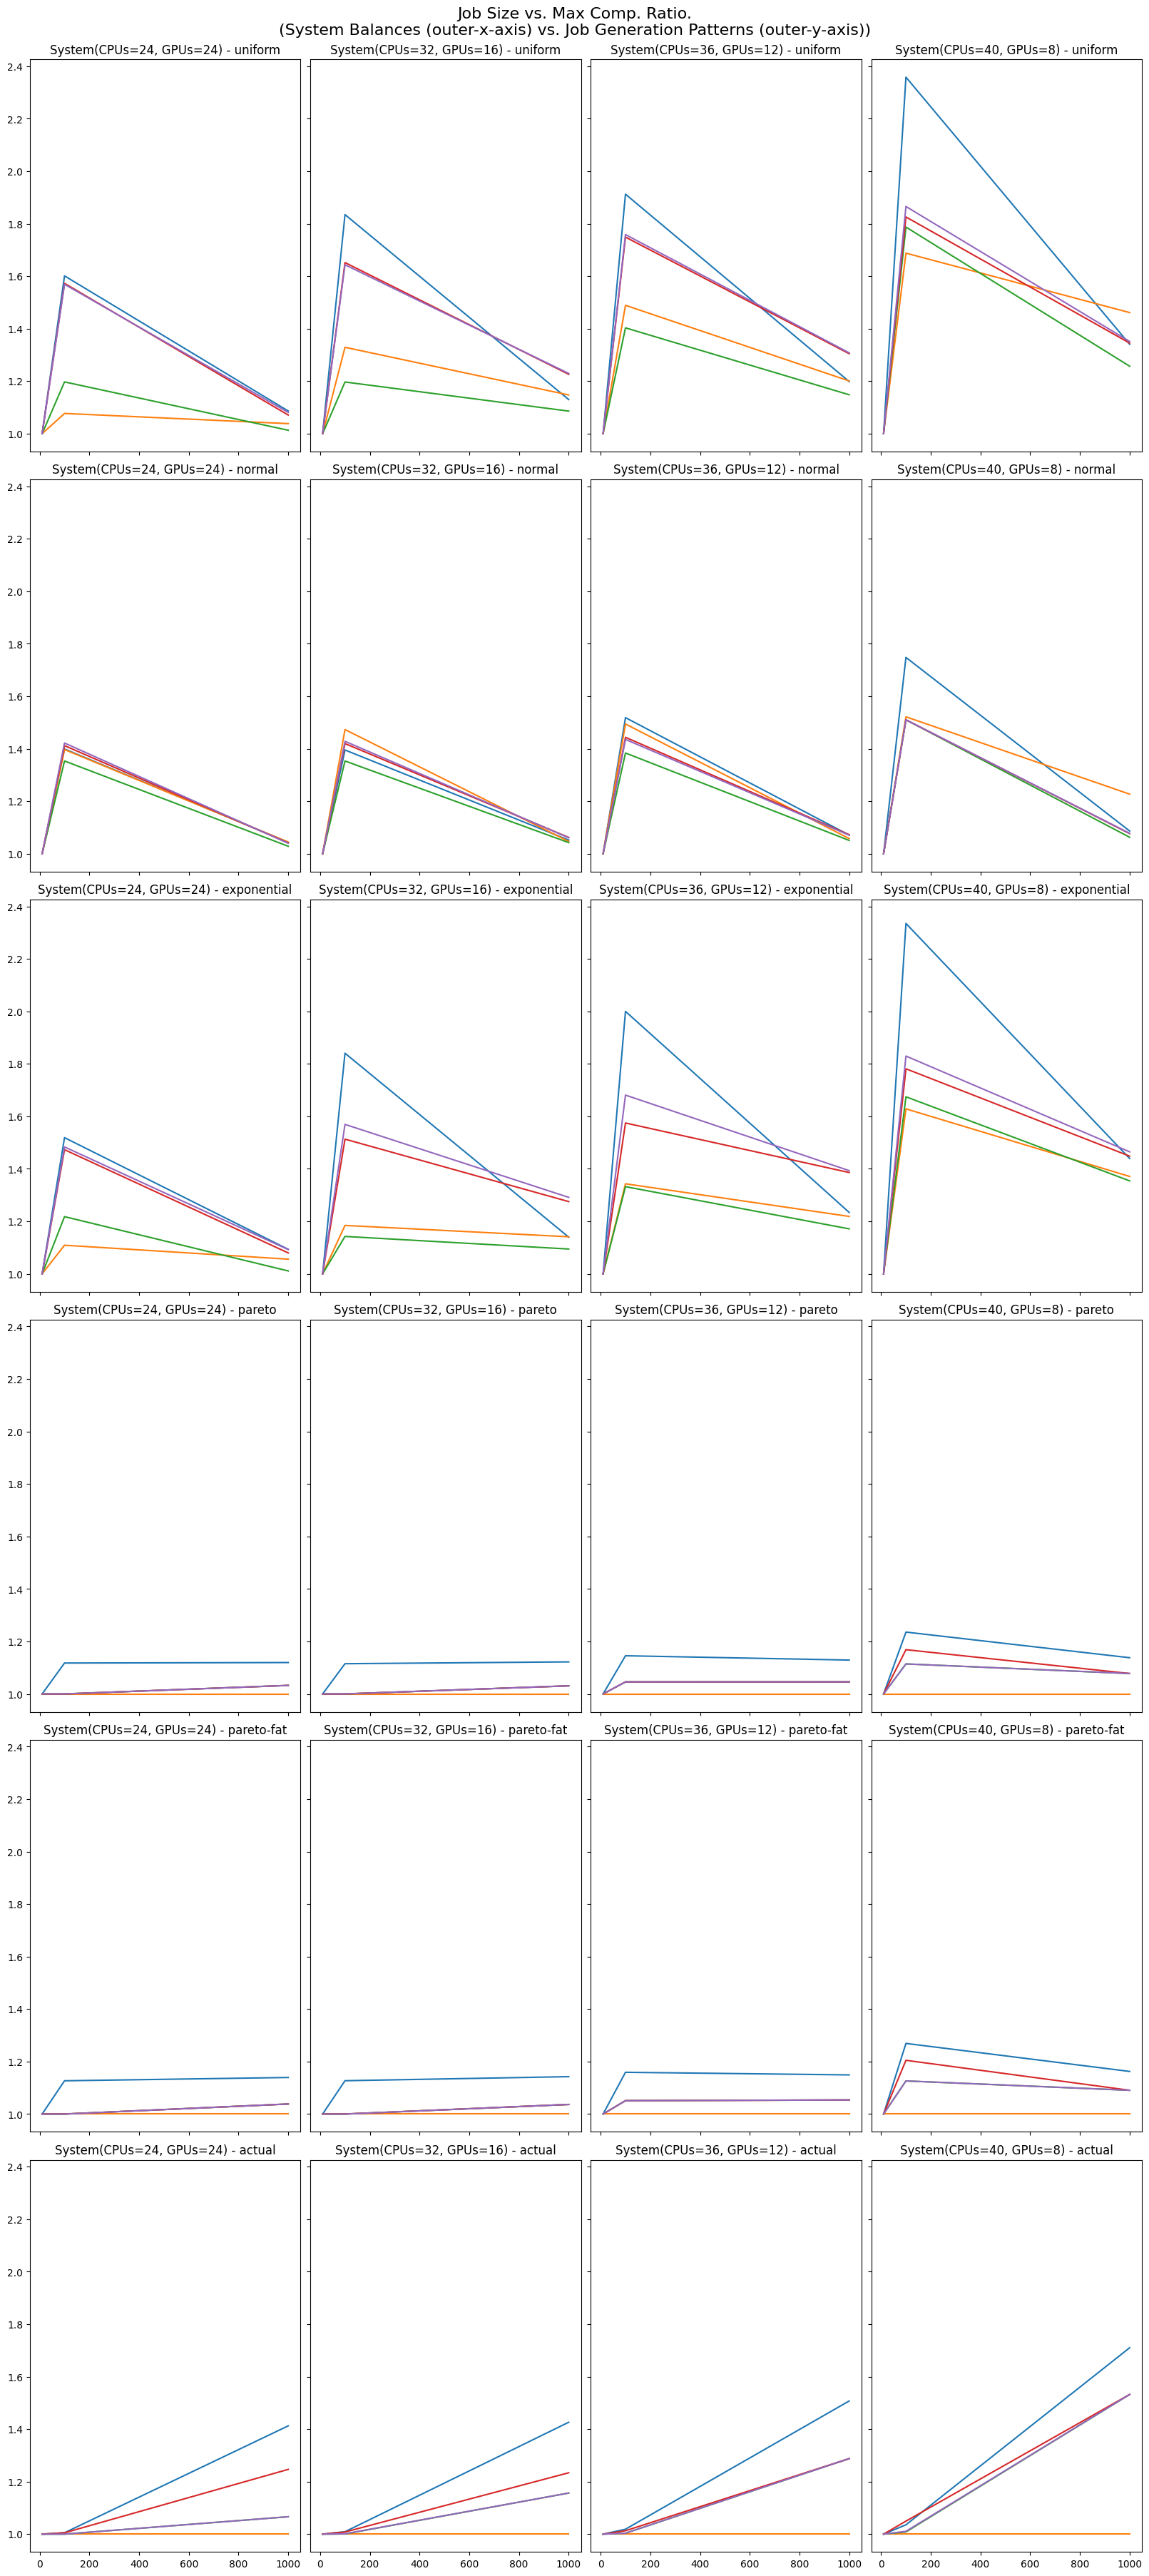

In [31]:
import matplotlib.pyplot as plt
from typing import Callable

SYSTEMS: list[Callable[[], system]] = [
    lambda: system(24, 24),
    lambda: system(32, 16),
    lambda: system(36, 12),
    lambda: system(40, 8),
]  # , lambda x: system(47, 1)]
# TEMPERATURES :list[tuple[float,float]] = [(0.5, 0.5), (0.5, 0.4), (0.5, 0.3), (0.5, 0.2), (0.5, 0.1), (0.5, 0)]
JOB_GEN_TYPES: list[str] = [
    "uniform",
    "normal",
    "exponential",
    "pareto",
    "pareto-fat",
    "actual",
]
ALGO_LOOKUP: list[str] = ["SCT", "SCT_LPT", "WC LPT", "Ratio", "Diff"]
MAGIC_TEMP = (0.15, 0.15)
NUM_TRIALS = 5
JOB_SIZES = [10**i for i in range(1, 4)]

# Create a grid for all graphs with shared axes
fig, axs = plt.subplots(
    len(JOB_GEN_TYPES),
    len(SYSTEMS),
    sharex=True,
    sharey=True,
    figsize=(len(SYSTEMS) ** 2, len(JOB_GEN_TYPES) ** 2),
    constrained_layout=True,
)

MAX_KEY = 3
MIN_KEY = 2
AVG_KEY = 1
NAME_KEY = 0

for idx, ax in enumerate(axs.ravel()):
    X = JOB_SIZES
    sys_entry = idx % len(SYSTEMS)
    gen_type_entry = idx // len(SYSTEMS)
    idx_label = f"Id: {idx} - System: {SYSTEMS[sys_entry]()!r} and Job Type: {JOB_GEN_TYPES[gen_type_entry]}"
    print(idx_label)
    jobs_list: list[list[float]] = [[] for i in range(len(ALGO_LOOKUP))]
    for size in JOB_SIZES:
        job_tuple = gen_jobs(size, NUM_TRIALS, MAGIC_TEMP)
        cur_job_entry = job_tuple[gen_type_entry]
        out = runMany_out(cur_job_entry, SYSTEMS[sys_entry]())
        for entry in range(len(out)):
            max_val = out[entry][MAX_KEY]
            jobs_list[entry].append(max_val)
    for l in jobs_list:
        ax.plot(X, l)
    graph_label = f"{SYSTEMS[sys_entry]()!r} - {JOB_GEN_TYPES[gen_type_entry]}"
    ax.set_title(graph_label)
    ax.label_outer()  # only show outer tick labels
# Add a super‑title
fig.suptitle(
    "Job Size vs. Max Comp. Ratio.\n(System Balances (outer-x-axis) vs. Job Generation Patterns (outer-y-axis))",
    fontsize=16,
)
plt.show()